# Data Exploration: LangGraph & LangChain Documentation

This notebook analyzes the two documentation files for the LangGraph Helper Agent:
- `langgraph-llms-full.txt` - Dedicated LangGraph docs (~16K lines)
- `langchain-llms-full.txt` - Unified LangChain docs (~144K lines)

**Goals:**
1. Parse and extract documents from both files
2. Analyze document statistics (count, length, tokens)
3. Detect content overlap between sources
4. Inform chunking strategy for RAG


In [1]:
!pip install matplotlib==3.10.7
!pip install seaborn==0.13.2

In [1]:
import os
import re
from pathlib import Path
from dataclasses import dataclass
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import google.genai as genai

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

DATA_DIR = Path("../data")


In [2]:
api_key = os.getenv("GOOGLE_API_KEY") or os.getenv("GEMINI_API_KEY")
client = None
if api_key:
    client = genai.Client(api_key=api_key)
    print("✓ Gemini API client initialized")
else:
    print("⚠ No API key found. Set GOOGLE_API_KEY or GEMINI_API_KEY")


✓ Gemini API client initialized


## 1. Document Parsing

Each file has a different format:
- **LangGraph**: `---\npath.md\n---\n# Title\ncontent`
- **LangChain**: `# Title\nSource: url\n\ncontent`


In [3]:
@dataclass
class Document:
    """Parsed document from llms.txt files."""
    title: str
    source: str  # file path or URL
    content: str
    source_file: str  # which llms.txt file it came from
    
    @property
    def char_count(self) -> int:
        return len(self.content)
    
    @property
    def word_count(self) -> int:
        return len(self.content.split())
    
    def __repr__(self):
        return f"Document(title='{self.title[:50]}...', chars={self.char_count})"


In [4]:
def parse_langgraph_file(filepath: Path) -> list[Document]:
    """
    Parse LangGraph llms-full.txt format.
    Format: ---\npath.md\n---\n# Title\ncontent\n---\n...
    """
    content = filepath.read_text(encoding="utf-8")
    
    # Split by document delimiter pattern
    # Pattern: ---\nfilepath.md\n---
    pattern = r"^---\n([\w\-/]+\.(?:md|ipynb))\n---\n"
    
    docs = []
    parts = re.split(pattern, content, flags=re.MULTILINE)
    
    # parts[0] is empty or preamble, then alternating: path, content, path, content...
    for i in range(1, len(parts), 2):
        if i + 1 >= len(parts):
            break
            
        path = parts[i].strip()
        doc_content = parts[i + 1].strip()
        
        # Extract title from first # heading
        title_match = re.search(r"^#\s+(.+)$", doc_content, re.MULTILINE)
        title = title_match.group(1) if title_match else path
        
        docs.append(Document(
            title=title,
            source=path,
            content=doc_content,
            source_file="langgraph"
        ))
    
    return docs


def parse_langchain_file(filepath: Path) -> list[Document]:
    """
    Parse LangChain llms-full.txt format.
    Format: # Title\nSource: url\n\ncontent\n\n***\n\n...
    """
    content = filepath.read_text(encoding="utf-8")
    
    # Split by title pattern (# at start of line, followed by Source:)
    # Each doc starts with # Title\nSource: url
    pattern = r"^(# .+?)\nSource: (https?://[^\n]+)\n"
    
    docs = []
    matches = list(re.finditer(pattern, content, re.MULTILINE))
    
    for i, match in enumerate(matches):
        title = match.group(1).lstrip("# ").strip()
        source = match.group(2).strip()
        
        # Content is from end of this match to start of next (or end of file)
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(content)
        doc_content = content[start:end].strip()
        
        # Clean up trailing separators
        doc_content = re.sub(r"\n\*{3}\s*$", "", doc_content)
        
        docs.append(Document(
            title=title,
            source=source,
            content=doc_content,
            source_file="langchain"
        ))
    
    return docs


In [5]:
# Parse both files
langgraph_docs = parse_langgraph_file(DATA_DIR / "langgraph-llms-full.txt")
langchain_docs = parse_langchain_file(DATA_DIR / "langchain-llms-full.txt")

print(f"LangGraph docs: {len(langgraph_docs)}")
print(f"LangChain docs: {len(langchain_docs)}")
print(f"\nSample LangGraph doc: {langgraph_docs[0]}")
print(f"Sample LangChain doc: {langchain_docs[0]}")


LangGraph docs: 59
LangChain docs: 575

Sample LangGraph doc: Document(title='How to interact with the deployment using RemoteGr...', chars=5820)
Sample LangChain doc: Document(title='null...', chars=5825)


## 2. Basic Statistics


In [6]:
def docs_to_df(docs: list[Document]) -> pd.DataFrame:
    """Convert documents to DataFrame for analysis."""
    return pd.DataFrame([
        {
            "title": d.title,
            "source": d.source,
            "source_file": d.source_file,
            "char_count": d.char_count,
            "word_count": d.word_count,
            "content": d.content,
        }
        for d in docs
    ])

df_lg = docs_to_df(langgraph_docs)
df_lc = docs_to_df(langchain_docs)

# Combined for comparison
df_all = pd.concat([df_lg, df_lc], ignore_index=True)

print("=== Document Count ===")
print(df_all.groupby("source_file").size())

print("\n=== Character Count Stats ===")
print(df_all.groupby("source_file")["char_count"].describe().round(0))


=== Document Count ===
source_file
langchain    575
langgraph     59
dtype: int64

=== Character Count Stats ===
             count     mean      std    min     25%     50%      75%      max
source_file                                                                  
langchain    575.0  11319.0  12577.0   52.0  3106.0  7095.0  15304.0  91005.0
langgraph     59.0  10669.0  11840.0  443.0  3154.0  6301.0  13566.0  66839.0


/var/folders/g9/5mxlzjpn6r36lyhl91c1cthr0000gn/T/ipykernel_94350/2902178792.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="source_file", y="char_count", ax=axes[1], palette=["#2ecc71", "#3498db"])


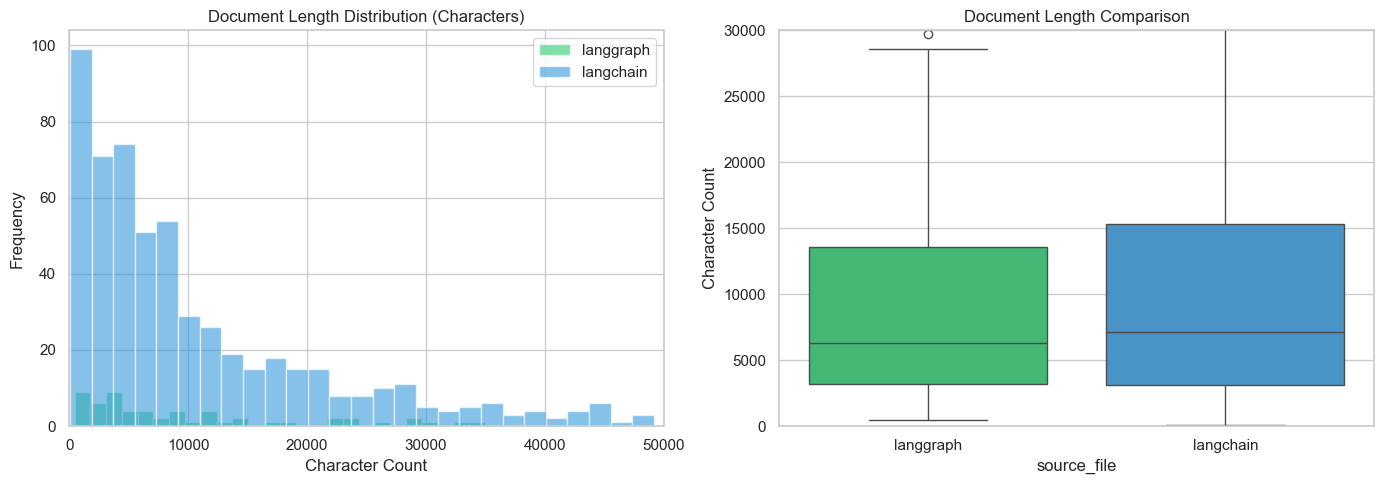

In [10]:
# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count distribution
for source, color in [("langgraph", "#2ecc71"), ("langchain", "#3498db")]:
    subset = df_all[df_all["source_file"] == source]["char_count"]
    axes[0].hist(subset, bins=50, alpha=0.6, label=source, color=color)
axes[0].set_xlabel("Character Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Document Length Distribution (Characters)")
axes[0].legend()
axes[0].set_xlim(0, 50000)  # Cap for visibility

# Box plot comparison
sns.boxplot(data=df_all, x="source_file", y="char_count", ax=axes[1], palette=["#2ecc71", "#3498db"])
axes[1].set_ylabel("Character Count")
axes[1].set_title("Document Length Comparison")
axes[1].set_ylim(0, 30000)

plt.tight_layout()
plt.show()


## 3. Token Counting with Gemini

Using Gemini's `count_tokens` API for accurate token counts (free tier).


In [13]:
def count_tokens_gemini(text: str, model_name: str = "gemini-2.0-flash") -> int:
    """Count tokens using Gemini API."""
    if client is None:
        return 0
    response = client.models.count_tokens(model=model_name, contents=text)
    return response.total_tokens


def count_tokens_batch(docs: list[Document], model_name: str = "gemini-2.0-flash") -> list[int]:
    """Count tokens for a batch of documents with progress bar."""
    token_counts = []
    for doc in tqdm(docs, desc="Counting tokens"):
        try:
            count = count_tokens_gemini(doc.content, model_name)
            token_counts.append(count)
        except Exception as e:
            print(f"Error counting tokens for '{doc.title[:30]}': {e}")
            # Fallback: rough estimate (4 chars per token)
            token_counts.append(doc.char_count // 4)
    return token_counts


In [14]:
# Count tokens for all documents
# Note: This may take a few minutes due to API calls

print("Counting tokens for LangGraph docs...")
lg_tokens = count_tokens_batch(langgraph_docs)
df_lg["token_count"] = lg_tokens

print("\nCounting tokens for LangChain docs...")
lc_tokens = count_tokens_batch(langchain_docs)
df_lc["token_count"] = lc_tokens

# Update combined df
df_all = pd.concat([df_lg, df_lc], ignore_index=True)


Counting tokens for LangGraph docs...


Counting tokens:   0%|          | 0/59 [00:00<?, ?it/s]


Counting tokens for LangChain docs...


Counting tokens:   0%|          | 0/575 [00:00<?, ?it/s]

In [15]:
print("=== Token Count Stats ===")
print(df_all.groupby("source_file")["token_count"].describe().round(0))

print("\n=== Total Tokens ===")
print(df_all.groupby("source_file")["token_count"].sum())


=== Token Count Stats ===
             count    mean     std    min    25%     50%     75%      max
source_file                                                              
langchain    575.0  3320.0  3810.0   16.0  799.0  1966.0  4496.0  30193.0
langgraph     59.0  2736.0  3230.0  109.0  634.0  1576.0  3537.0  18407.0

=== Total Tokens ===
source_file
langchain    1908984
langgraph     161450
Name: token_count, dtype: int64


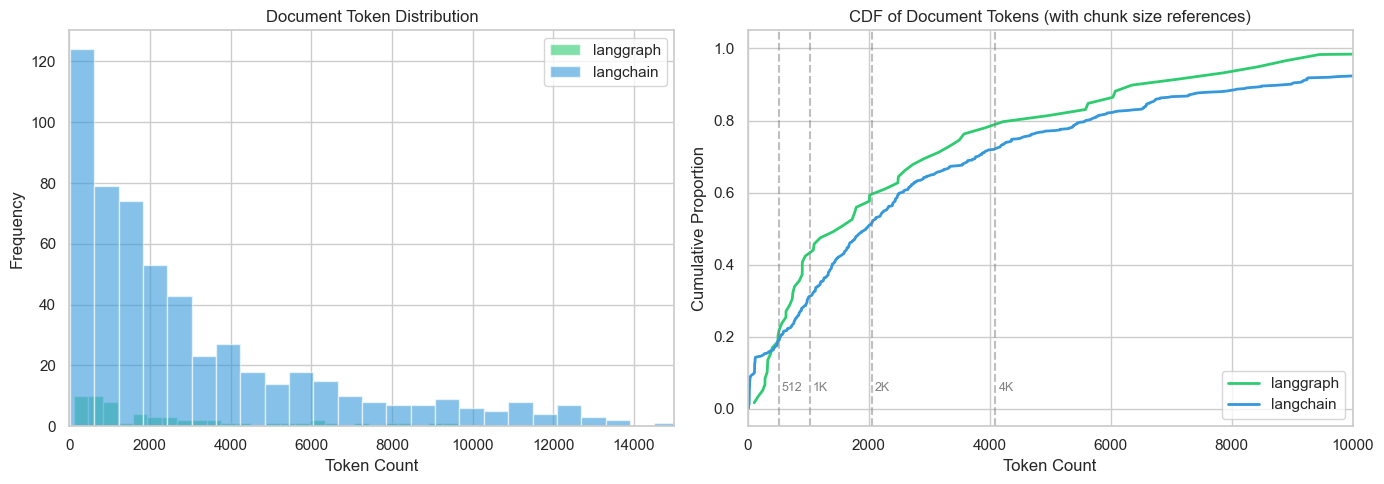

In [16]:
# Token distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
for source, color in [("langgraph", "#2ecc71"), ("langchain", "#3498db")]:
    subset = df_all[df_all["source_file"] == source]["token_count"]
    axes[0].hist(subset, bins=50, alpha=0.6, label=source, color=color)
axes[0].set_xlabel("Token Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Document Token Distribution")
axes[0].legend()
axes[0].set_xlim(0, 15000)

# CDF - useful for chunking decisions
for source, color in [("langgraph", "#2ecc71"), ("langchain", "#3498db")]:
    subset = df_all[df_all["source_file"] == source]["token_count"].sort_values()
    cdf = np.arange(1, len(subset) + 1) / len(subset)
    axes[1].plot(subset, cdf, label=source, color=color, linewidth=2)

# Add reference lines for common chunk sizes
for size, label in [(512, "512"), (1024, "1K"), (2048, "2K"), (4096, "4K")]:
    axes[1].axvline(x=size, color="gray", linestyle="--", alpha=0.5)
    axes[1].text(size + 50, 0.05, label, fontsize=9, color="gray")

axes[1].set_xlabel("Token Count")
axes[1].set_ylabel("Cumulative Proportion")
axes[1].set_title("CDF of Document Tokens (with chunk size references)")
axes[1].legend()
axes[1].set_xlim(0, 10000)

plt.tight_layout()
plt.show()


## 4. Content Overlap Analysis

Check if LangChain file contains duplicate LangGraph content.


In [17]:
# Identify LangGraph docs within LangChain file
df_lc["is_langgraph"] = df_lc["source"].str.contains("/langgraph/", case=False)

lc_langgraph_docs = df_lc[df_lc["is_langgraph"]]
lc_other_docs = df_lc[~df_lc["is_langgraph"]]

print(f"LangChain file breakdown:")
print(f"  - LangGraph content: {len(lc_langgraph_docs)} docs")
print(f"  - Other content: {len(lc_other_docs)} docs")
print(f"\nDedicated LangGraph file: {len(df_lg)} docs")


LangChain file breakdown:
  - LangGraph content: 55 docs
  - Other content: 520 docs

Dedicated LangGraph file: 59 docs


In [18]:
# Compare titles to find potential duplicates
def normalize_title(title: str) -> str:
    """Normalize title for comparison."""
    return re.sub(r"[^a-z0-9]", "", title.lower())

lg_titles_normalized = set(df_lg["title"].apply(normalize_title))
lc_lg_titles_normalized = set(lc_langgraph_docs["title"].apply(normalize_title))

# Find overlapping titles
overlapping_titles = lg_titles_normalized & lc_lg_titles_normalized
print(f"\nOverlapping titles (normalized): {len(overlapping_titles)}")

# Show some examples
if overlapping_titles:
    print("\nSample overlapping titles:")
    for title in list(overlapping_titles)[:10]:
        # Find original titles
        lg_match = df_lg[df_lg["title"].apply(normalize_title) == title]["title"].iloc[0]
        lc_match = lc_langgraph_docs[lc_langgraph_docs["title"].apply(normalize_title) == title]["title"].iloc[0]
        print(f"  - LG: '{lg_match[:60]}'")
        print(f"    LC: '{lc_match[:60]}'\n")



Overlapping titles (normalized): 8

Sample overlapping titles:
  - LG: 'Subgraphs'
    LC: 'Subgraphs'

  - LG: 'Memory'
    LC: 'Memory'

  - LG: 'Persistence'
    LC: 'Persistence'

  - LG: 'Application Structure'
    LC: 'Application structure'

  - LG: 'Use the functional API'
    LC: 'Use the functional API'

  - LG: 'Streaming'
    LC: 'Streaming'

  - LG: 'Durable Execution'
    LC: 'Durable execution'

  - LG: 'LangGraph runtime'
    LC: 'LangGraph runtime'



In [19]:
# Content similarity for overlapping docs
from difflib import SequenceMatcher

def content_similarity(text1: str, text2: str) -> float:
    """Calculate similarity ratio between two texts."""
    return SequenceMatcher(None, text1, text2).ratio()

# Compare content for docs with matching titles
similarity_results = []
for norm_title in list(overlapping_titles)[:20]:  # Sample first 20
    lg_row = df_lg[df_lg["title"].apply(normalize_title) == norm_title].iloc[0]
    lc_row = lc_langgraph_docs[lc_langgraph_docs["title"].apply(normalize_title) == norm_title].iloc[0]
    
    sim = content_similarity(lg_row["content"], lc_row["content"])
    similarity_results.append({
        "title": lg_row["title"][:50],
        "similarity": sim,
        "lg_chars": lg_row["char_count"],
        "lc_chars": lc_row["char_count"],
    })

df_sim = pd.DataFrame(similarity_results)
if len(df_sim) > 0:
    print("Content Similarity for Overlapping Docs:")
    print(df_sim.to_string(index=False))
    print(f"\nMean similarity: {df_sim['similarity'].mean():.2%}")
else:
    print("No overlapping documents found.")


Content Similarity for Overlapping Docs:
                 title  similarity  lg_chars  lc_chars
             Subgraphs    0.048979      3396     18001
                Memory    0.022503     18708     27864
           Persistence    0.445649     28587     35082
 Application Structure    0.639708      4696      4627
Use the functional API    0.373544     29737     27959
             Streaming    0.007084      1450     24242
     Durable Execution    0.617645     11487     11727
     LangGraph runtime    0.620162     12388     12957

Mean similarity: 34.69%


## 5. Content Category Analysis

Understand what topics are covered in each source.


In [20]:
# Extract categories from paths/URLs
def extract_category(source: str, source_file: str) -> str:
    """Extract top-level category from source path/URL."""
    if source_file == "langgraph":
        # Format: how-tos/file.md or concepts/file.md
        parts = source.split("/")
        return parts[0] if parts else "unknown"
    else:
        # Format: https://docs.langchain.com/langsmith/topic or /oss/python/langgraph/topic
        if "/oss/python/" in source:
            # Extract library name
            match = re.search(r"/oss/python/([^/]+)", source)
            return f"oss/{match.group(1)}" if match else "oss/other"
        elif "/langsmith/" in source:
            return "langsmith"
        else:
            return "other"

df_all["category"] = df_all.apply(
    lambda r: extract_category(r["source"], r["source_file"]), axis=1
)

print("=== LangGraph File Categories ===")
print(df_all[df_all["source_file"] == "langgraph"]["category"].value_counts())

print("\n=== LangChain File Categories ===")
print(df_all[df_all["source_file"] == "langchain"]["category"].value_counts())


=== LangGraph File Categories ===
category
concepts    38
how-tos     21
Name: count, dtype: int64

=== LangChain File Categories ===
category
langsmith              329
other                  127
oss/langchain           34
oss/langgraph           28
oss/integrations        18
oss/contributing        12
oss/deepagents          10
oss/reference            5
oss/releases             3
oss/concepts             2
oss/migrate              2
oss/common-errors        1
oss/learn                1
oss/release-policy       1
oss/security-policy      1
oss/versioning           1
Name: count, dtype: int64


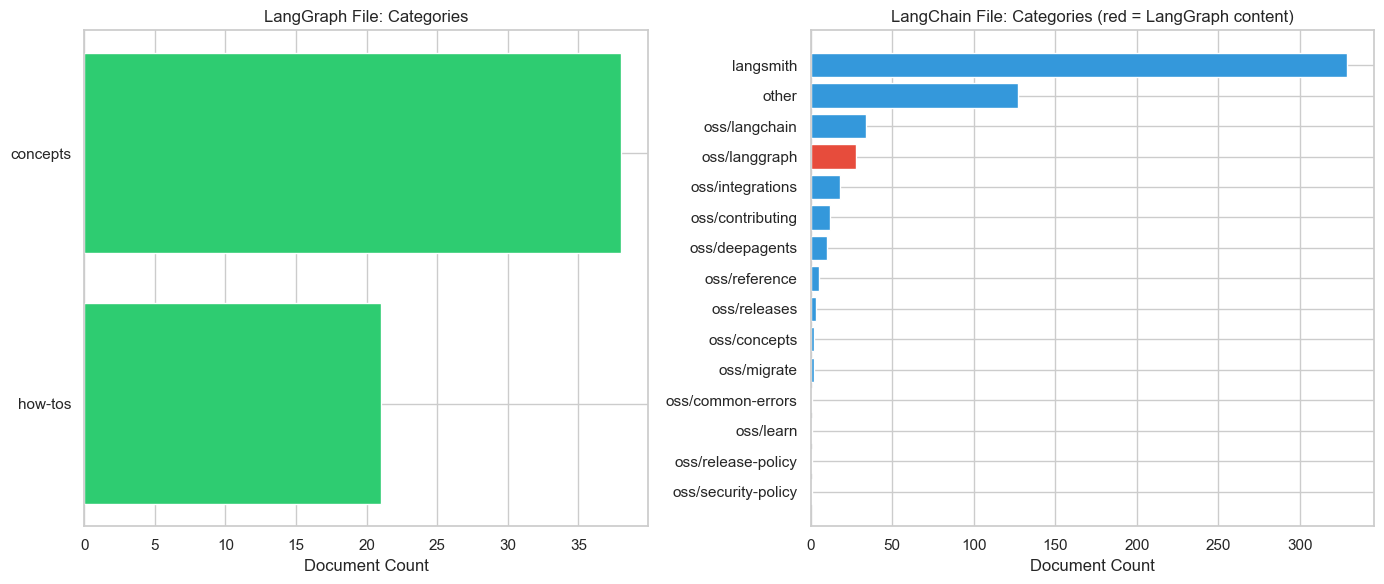

In [21]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LangGraph categories
lg_cats = df_all[df_all["source_file"] == "langgraph"]["category"].value_counts()
axes[0].barh(lg_cats.index, lg_cats.values, color="#2ecc71")
axes[0].set_xlabel("Document Count")
axes[0].set_title("LangGraph File: Categories")
axes[0].invert_yaxis()

# LangChain categories (top 15)
lc_cats = df_all[df_all["source_file"] == "langchain"]["category"].value_counts().head(15)
colors = ["#e74c3c" if "langgraph" in cat else "#3498db" for cat in lc_cats.index]
axes[1].barh(lc_cats.index, lc_cats.values, color=colors)
axes[1].set_xlabel("Document Count")
axes[1].set_title("LangChain File: Categories (red = LangGraph content)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
